In [2]:
%%capture
%load_ext autoreload
%autoreload 2
%pylab inline
%cd '/home/allan/research/tutorials/robust_stats_hcdsb'

In [3]:
from IPython.display import Markdown
#set_matplotlib_formats('png')
#import yaml
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#np.seterr(divide='ignore', invalid='ignore')
from IPython.core.display import Image, display, HTML
from IPython.display import Markdown
import json  # need it for json.dumps
import altair as alt
from altair.vega import v3

In [4]:
## run this code but don't worry about what it does
#import altair as alt

def workshop_theme(*args, **kwargs):
    return {
            "width": 200,
            "height": 200,
            "config": {
              "title": {
                  'fontSize': 15
              },
              "numberFormat": ".0f",
              "style": {
                "bar": {
                  "size": 20
                },
                "guide-title": {
                  "value": 'asdf',
                  "fontSize": 15
                },
                "guide-label": {
                  "fontSize": 15
                },
              },
              "scale": {
                "bandPaddingInner": 0.5,
                "bandPaddingOuter": 0.5
              },
              "legend": {
                "symbolSize": 100,
                "titleFontSize": 15,
                "labelFontSize": 15
              },
              "axis": {
                "titleFontSize": 15,
                "labelFontSize": 15,
                "labelLimit": 1000
              },
            }
          }
          

alt.themes.register('workshop_theme', workshop_theme)
alt.themes.enable('workshop_theme');
#themes.enable('default')

In [5]:
import json  # need it for json.dumps
#import altair as alt
#from altair.vega import v3
#import pandas as pd
#import numpy as np
#from IPython.core.display import Image, display, HTML

# Create the correct URLs for require.js to find the Javascript libraries
vega_url = 'https://cdn.jsdelivr.net/npm/vega@' + v3.SCHEMA_VERSION
vega_lib_url = 'https://cdn.jsdelivr.net/npm/vega-lib'
vega_lite_url = 'https://cdn.jsdelivr.net/npm/vega-lite@' + alt.SCHEMA_VERSION
vega_embed_url = 'https://cdn.jsdelivr.net/npm/vega-embed@3'
noext = "?noext"

paths = {
    'vega': vega_url + noext,
    'vega-lib': vega_lib_url + noext,
    'vega-lite': vega_lite_url + noext,
    'vega-embed': vega_embed_url + noext
}

workaround = """
requirejs.config({{
    baseUrl: 'https://cdn.jsdelivr.net/npm/',
    paths: {paths}
}});
"""

HTML("".join((
    "<script>",
    workaround.format(paths=json.dumps(paths)),
    "</script>",
    " "
)))

In [6]:
# Define the function for rendering

def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        """Render an altair chart directly via javascript.
        
        This is a workaround for functioning export to HTML.
        (It probably messes up other ways to export.) It will
        cache and autoincrement the ID suffixed with a
        number (e.g. vega-chart-1) so you don't have to deal
        with that.
        """
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay defined and keep track of the unique div Ids
    return wrapped


@add_autoincrement
def render(chart, id="vega-chart"):
    # This below is the javascript to make the chart directly using vegaEmbed
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vegaEmbed) {{
        const spec = {chart};     
        vegaEmbed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
    }});
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )

In [1]:
#display(Image(filename="/home/allan/Pictures/hcdsb.png"))

## Basic inferential stats review
- definitions are simplistic on purpose
- try google if you need more information, or call me
- apologies for the spelling mistakes

### Distributions

- a distribution is a chart that shows the frequency of values in a dataset
- we give distributions names based on their shape, for example:

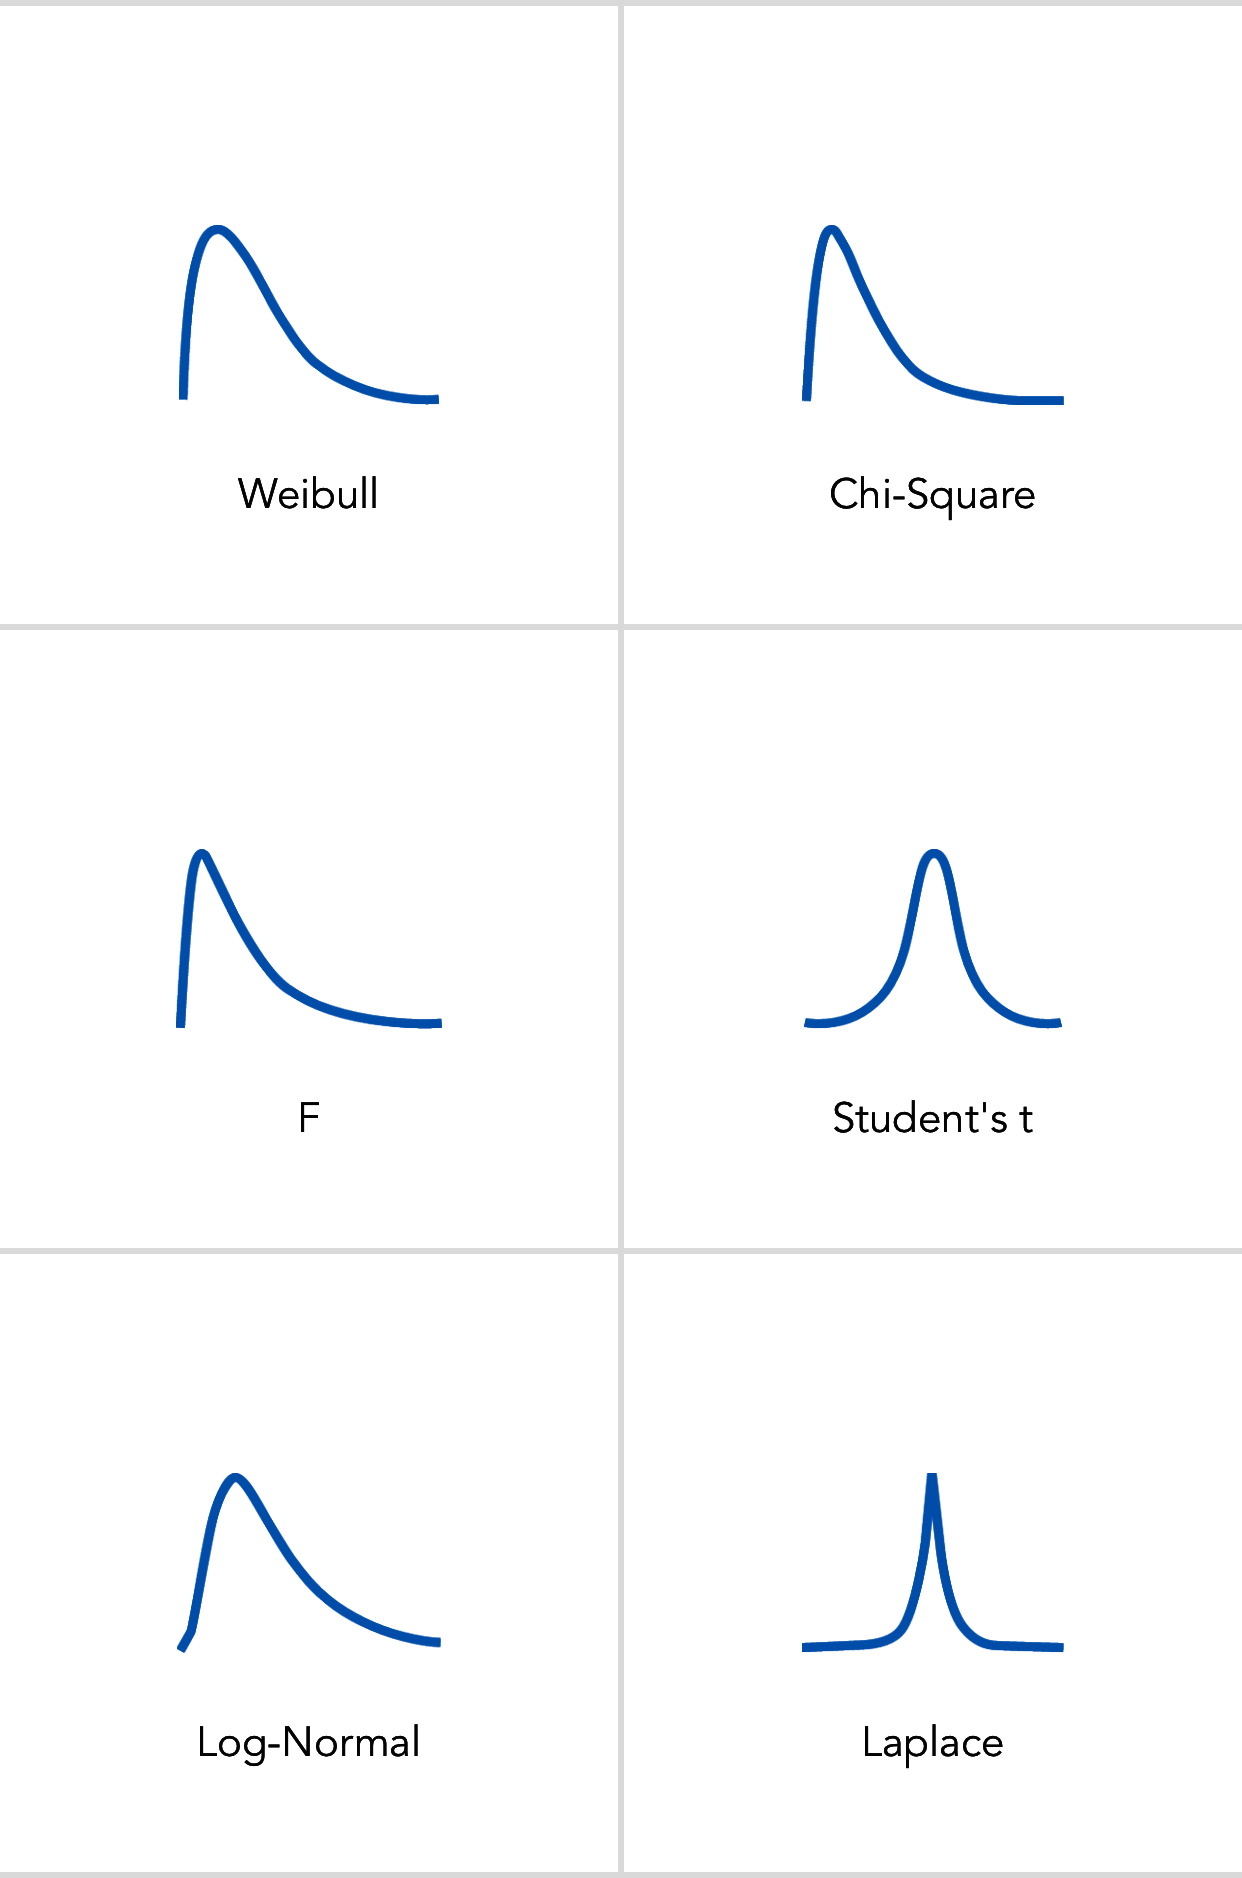

In [35]:
display(Image(filename="/home/allan/research/tutorials/robust_stats_hcdsb/dist_gimp.png",width=500))

- distributions can be characterized broadly as heavy-tailed or light tailed, and skewed or symetrical
- the edges of distributions are called tails, the part where most values are clustered is called the bulk
- in the above image, Student's t would be considered light-tailed and symetric whereas log-normal is light-tailed and skewed
 - we will see examples of heavey tailed distributions in the workshop. Basically, any distribution that contains outliers is heavy-tailed
- in inferential statistics we do not compare single values, but rather we compare distributions

### Population versus sample
- a population is a set of all possible values of interest
- a sample is a subset of the population
- you could argue that it is extremely rare to ever truly obtain a dataset that contains the entire population (i.e., it is theoretical)
- we make inferences about the population based on our sample

### Measures of central tendency and scale 
#### central tendency
- we often have a goal of trying to summarize a set of values with one value
- examples of measures of central tendency are the mean (average), median, mode, trimmed mean, winsorized mean, harmonic mean, M-estimators
- in symbols, we differentiate these estimators based on whether or not we are referring to the sample or the population, for example:

sample mean:
X̄

population mean:
μ

#### scale
- measures of scale tell us about how spread out or tightly clustered our distribution is
- examples of measures of scale are standard deviation, standard error, variance, mean absolute deviation
- in symbols, we differentiate these estimators based on whether or not we are referring to the sample or the population, for example:

sample standard deviation:
s or (SD)

population standard deviation:
σ

an example of the formula for caculating the variance of any estimator is as follows:

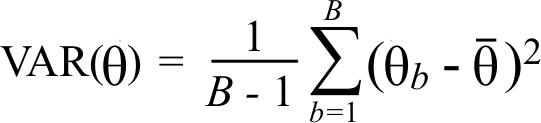

In [34]:
display(Image(filename="/home/allan/research/tutorials/robust_stats_hcdsb/var.png",width=300))

- look at the parentheses that contain the greek symbol for theta (&Theta;). The symbol with the line above it is any measure of central tendency (mean, median, whatever)
- the theta symbol with the little "b" next to it represents the individual values in the dataset
- the point is that this formula is looking at how "far away" individual values are from the measure of central tendency you are interested in
 - Let's pretend that we are interested in the mean (average)
   - if values are close to the mean, variance will be small, if values are very far from the mean, variance will be large

### Null and alternative hypotheses

- all statistical tests compare the sample data to what would be expected purely by chance
- if our results look similar to what we'd get by chance, we say "nothing interesting going on here"
- if our results look very different from chance we say "yay, we found something interesting"
- for example, suppose you want to test if a coin is biased (more likely to fall on heads than tails) 
    - you can test this by flipping the coin 1 million times and counting the number of heads
    - if your results are quite unlike a 50/50 split, then you conclude that the coin is biased
- we formalize this idea in two sentences called the null and alternative hypothesis, respectively

    - Null: I expect that the number of heads and tails will be similar (the null hypothesis)
    - Alternative: I expect that the number of heads and tails will not be similar (the alternative hypothesis)
    
- since we know what chance (randomness) looks like (i.e., we can just ask a computer), we can use that fact as a way of determining if our results are interesting (or systematic)
- of course you cannot flip a coin (or repeat an experiment) a million times, so we have formulas to simulate that process (and they can easily fail which we will discuss)


### Statistical tests
- statistical tests give us numbers that quantify how similar our results are to the null (chance factors)
- two such metrics are the p-value and confidence intervals (described below)
- common tests are t-test, f-test (ANOVA), chi-squared, bootstrap, permutation ...
- we also have tests for determining if a correlation unlikely by chance
- the main idea with all tests is "effect over error", put another way, we want to take the difference between groups and divide that by the amount of variability in the data
    - if there is a lot of variability and small group differences, we won't be likey to find any thing interesting (becasue there is too much noise in the data)
    - if there are large group differences and a small amount of variability, we will be more likely to find something interesting (the data are not looking random, but rather systematic)
- you can see "effect over error" in the formula for a t-test below
 - the numerator is a difference score (the effect)
 - the denominator is a measure of variability (the error)


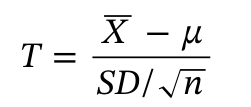

In [30]:
display(Image(filename="/home/allan/research/tutorials/robust_stats_hcdsb/ttest.png",width=200))

- many researchers use tests that were develped over a century ago (e.g., t-test). As early as 1960, serious problems with such tests were being discovered and in the years since then, many substaintial improvements have been made (there are thousands of papers on robust methods)
- traditional statistical tests have assumptions; conditions that you need to meet, if you want interpretible results
 - the most famous assumption of traditional tests is that the data are assumed to come from a normal distribution. 
 - well, to be honest, this isn't really correct. The correct way of describing the assumption of normailty is as follows:
 
 
 We assume that, if we were to repeat a study oodles of times with different samples, the resulting distribution of means across studies should be normal. (this doesn't apply just to means, but any measure of interest)
 
 - such a distribution is called a "sampling distribution", since it is a distribution arising from repeated samples
 - we'll talk about this in detail during the workshop. 
 - one thing to note is that traditional statistics does not require the population or sample to be normally distributed, only the sampling distribution

### p-value
- a number in the range of 0-1
- Definition: the probability of the obtained data, given the null hypothesis
    - CAREFUL: this is not the same as "the probability of the null hypothesis, given the data"
    - this is counter intuitive but you can ask me more during the workshop if you are interested in why the above statements are not the same. Or google "inverse probability fallacy".
    - to be honest, we really want to know whether or not the null is true, but statistics cannot tell us this. Consider this statement from Jacob Cohen:
    
    > “a p-value does not tell us what we want to know, and we so much want to know what we want to know that, out of desperation, we nevertheless believe that it does!” 
    
    And from Geoff Cumming
    
     > "we want to know whether the null is true, but a p-value doesn't measure that, it measures the probability of the obtained data, given the null hypothesis. In desperation we believe that a p-value measures the probability of the null hypothesis, given the data, and unfortunately, some textbooks perpetuate this error"
     
- the point here is that p-values are often misunderstood and are counter intuitive, and yet they are still somewhat important when understood correctly
    
    
### Confidence Interval (CI)
- unlike a p-value, a CI gives you a range estimate
- for example, I am 95% sure that the difference between males and females on an intelligence test is 20, plus or minus 10
- the CI is an estimate of the upper and lower bounds surounding the population measure of central tendency
- of course we never have the full population, so that is why the CI is only an estimate
- the wider a CI is the less precise a result. Compare the following:
 - males and females differ in intelligence on average by 5 points, plus or minus 2 points, versus,
 - males and females differ in intelligence on average by 5 points, plus or minus 50 points
- clearly the second statement could easily have said "there is not really a difference in intelligence between males and females"
- in general, when testing for differences, if a CI includes zero, there is no statistical effect, otherwise there is; however, even if zero is not contained in the CI, if the upper or lower boundary is very close to zero, the result is likely less impressive



### Effect sizes
- the degree to which two groups differ (or multiple groups)
- the simplest example of an effect size is a difference score. For example, men score 100, and women score 150 on some scale. Therefore the difference score is: men-women = -50.
- many times difference scores are "standardized", which just means that they are divided by some measure of scale so that their units are comparable across studies
- the main thing to know about effect sizes is that, while a p-value tells us how likely our obtained data are (assuming the null), effect sizes tell us *how* different, or you could say "the extent to which groups differ"

### Power
- all you need to know is that power is a number between 0-1 that tells us BEFORE an experiment how likely we are to find a non-random (systematic, statistical, etc) result.
- technical definition:
 - power is the probability of finding a statistical result, assuming the null hypothesis is true
- the higher the power the better
- most studies have really low power becasue samples sizes and the effect of interest are usually small  
- importantly, traditional statistical tests have low power (poor ability to detect true effects)
 - this is becasue traditional tests are adversely affected by the shapes of the distributions and outliers
- robust tests have much higher power over a large range of commonly encountered situations

### Type I and Type II error
- these are fancy terms for false positive and false negative, respectively
- for example, suppose we run a statistical test to see if our results are meaningful. If we conclude that there is a statistical difference between groups but inreality there is NOT a difference, we have committed a Type I error (the result is a false positive)

- on the other hand, if we conclude that there is no statistical difference (i.e., nothing that interesting seems to be happening with our results), but in reality there really IS a difference in the population, we have committed a Type II error (false negative)

- there are many reasons why we may committ a type I or type II error:
 - outliers
 - the shape of the population distribution (I will discuss the in the workshop; note that we never know the shape of the population)
 - p-hacking (fudging with the data until a p-value is sufficiently low)
 - insufficient sample size
 - variability in our data that we are not interested in that adds random noise or systematic changes in the data (yikes!)
 - low power
 - small effect sizes in the population
 - using an inappropriate test
 - many more...
 
 